In [1]:
%matplotlib inline
import chainer
import matplotlib.pyplot as plt
import net_2
import numpy as np
import os
import chainer.functions as F
from train_vae_with_specified_label import *

In [2]:
# set paths and paramters
out_dir_path = './result'
log_path = os.path.join(out_dir_path, 'log')
model_name = 'model_100.npz'
dimz = 100

In [3]:
# load a model
model = net_2.VAE(784, dimz, 500, F.softplus) 
chainer.serializers.load_npz(os.path.join(out_dir_path, model_name), model, strict=True)
model.to_cpu()

In [4]:
# load dataset
src_train, src_test = chainer.datasets.get_mnist(withlabel=True) 

In [5]:
# extract specified labels
specified_label = 5
train = extract_specified_labels(src_train, specified_label)
test = extract_specified_labels(src_test, specified_label)

In [6]:
def save_images(x, filename):
    fig, ax = plt.subplots(3, 3, figsize=(9, 9), dpi=100)
    for ai, xi in zip(ax.flatten(), x):
        ai.imshow(xi.reshape(28, 28))
    fig.savefig(filename)

In [7]:
# encode and decode training dataset
train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]  
x = chainer.Variable(np.asarray(train[train_ind])) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    x1 = model(x) 

train


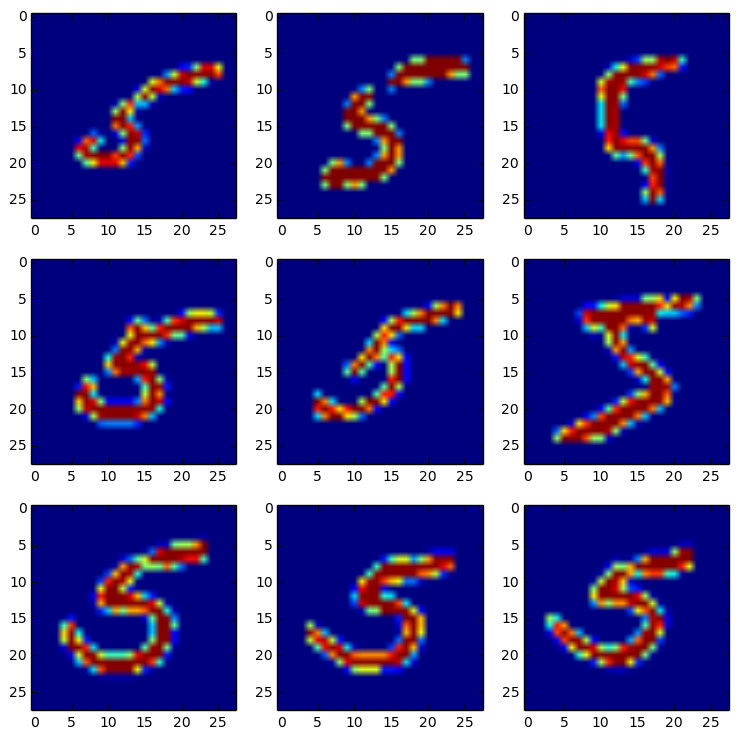

In [8]:
print('train')
save_images(x.data, os.path.join(out_dir_path, 'train')) 

train_reconstructed


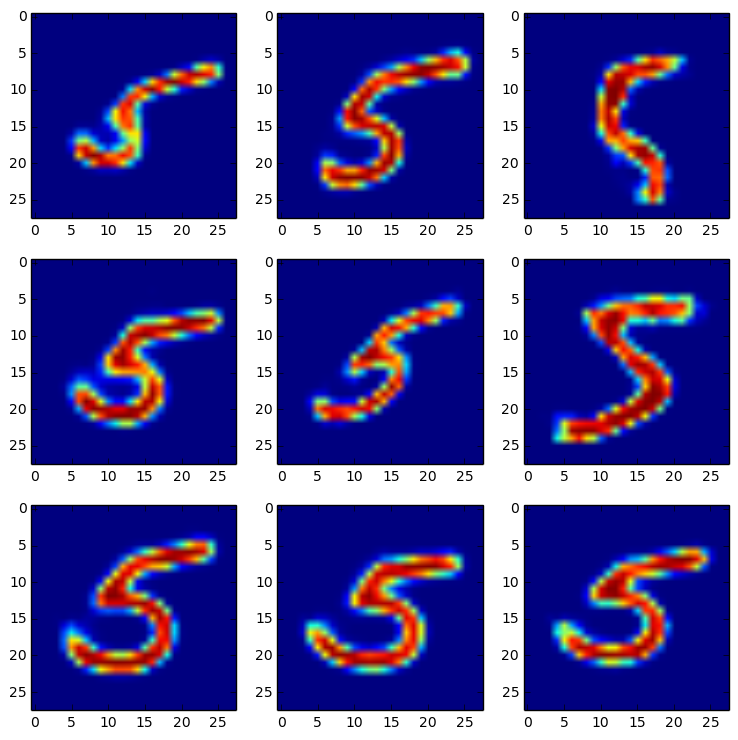

In [9]:
print('train_reconstructed')
save_images(x1.data, os.path.join(out_dir_path, 'train_reconstructed'))  

In [10]:
# # encode and decode training dataset
test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
x = chainer.Variable(np.asarray(test[test_ind]))
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x1 = model(x)

test


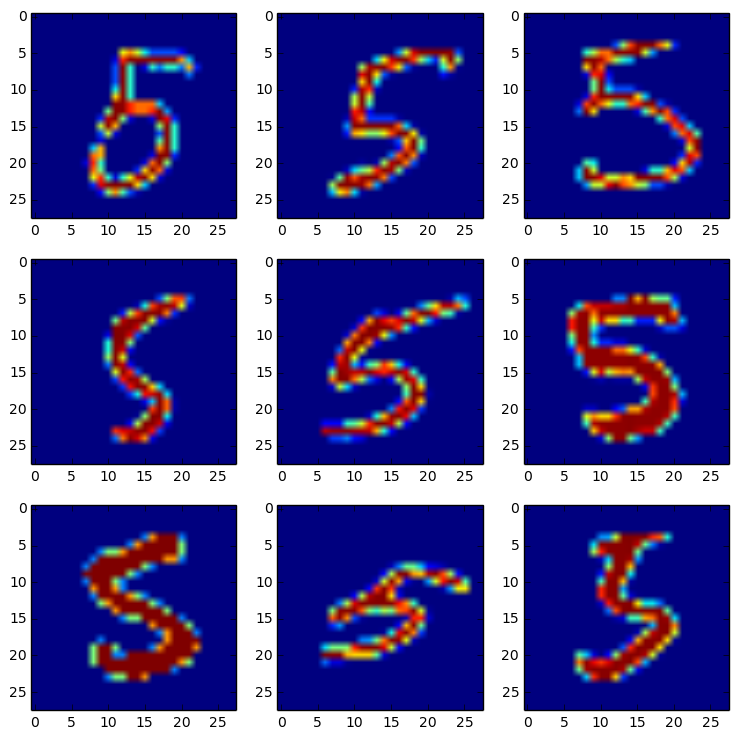

In [11]:
print('test')    
save_images(x.data, os.path.join(out_dir_path, 'test'))

test reconstructed


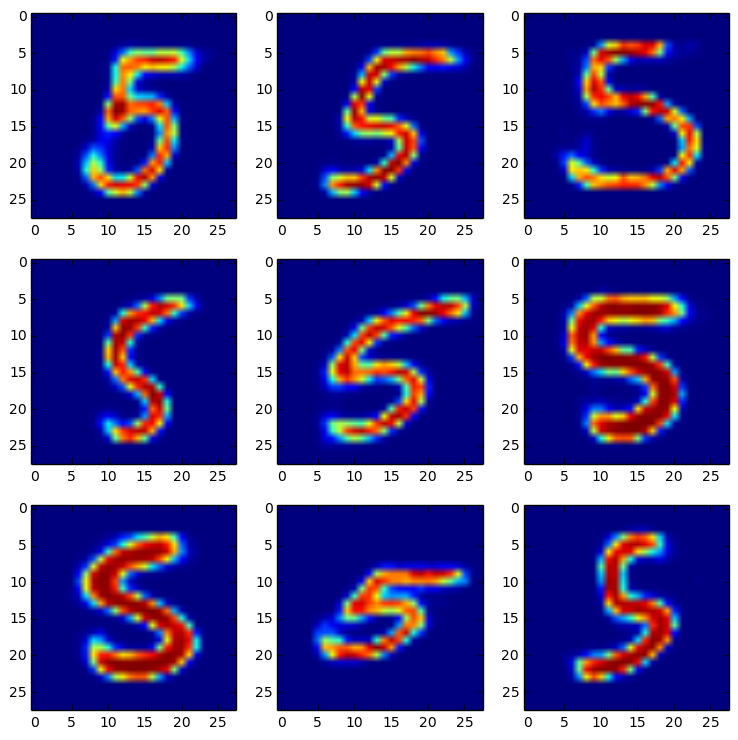

In [12]:
print('test reconstructed')
save_images(x1.data, os.path.join(out_dir_path, 'test_reconstructed'))

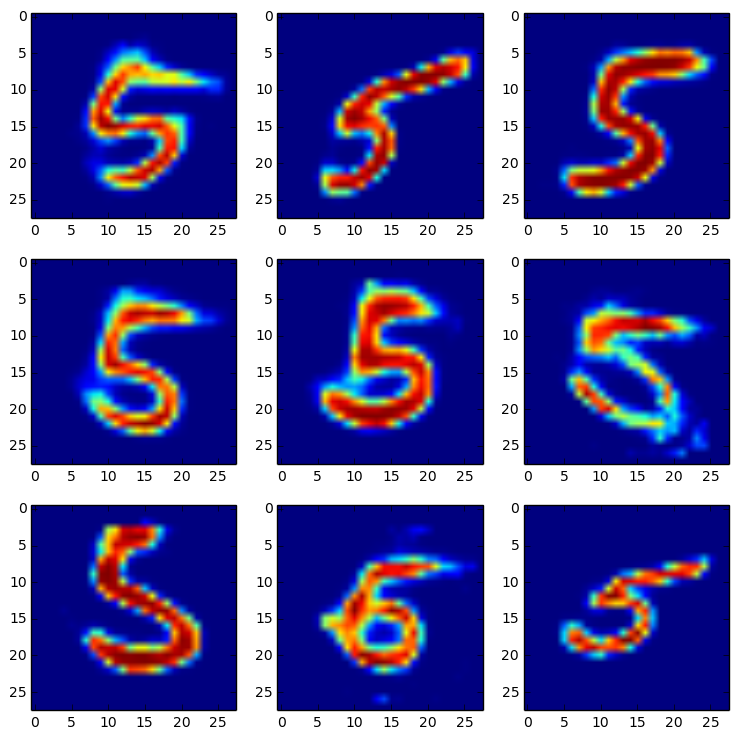

In [13]:
# draw images from randomly sampled z
np.random.seed(1234)
z = chainer.Variable(
    np.random.normal(0, 1, (9, dimz)).astype(np.float32))
x = model.decode(z)
save_images(x.data, os.path.join(out_dir_path, 'sampled'))

In [14]:
def load_loss(path):
    return [float(line) for line in open(path)]

import re
def loss_generator(path, s):
    s = re.compile(r'"{}": (-?[0-9]+.[0-9]+),?'.format(s))
    for line in open(path):
        m = s.findall(line)
        if m:
            yield float(m[0])

In [15]:
main_loss = list(loss_generator(log_path, 'main/loss'))
validation_main_loss = list(loss_generator(log_path, 'validation/main/loss'))
main_mu = list(loss_generator(log_path, 'main/mu'))
validation_main_mu = list(loss_generator(log_path, 'validation/main/mu'))
main_sigma = list(loss_generator(log_path, 'main/sigma'))
validation_main_sigma = list(loss_generator(log_path, 'validation/main/sigma'))

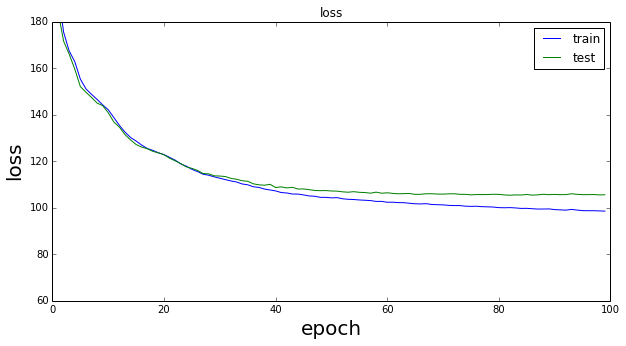

In [16]:
plt.figure(figsize=(10, 5))
plt.title('loss')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.xlim(0, 100)
plt.ylim(60, 180)
plt.plot(main_loss, label='train')
plt.plot(validation_main_loss, label='test')
plt.legend(loc='best')
plt.show()

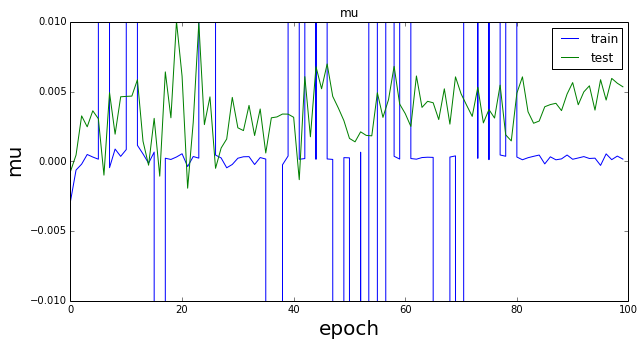

In [17]:
plt.figure(figsize=(10, 5))
plt.title('mu')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('mu', fontsize=20)
plt.xlim(0, 100)
plt.ylim(-0.01, 0.01)
plt.plot(main_mu, label='train')
plt.plot(validation_main_mu, label='test')
plt.legend(loc='best')
plt.show()

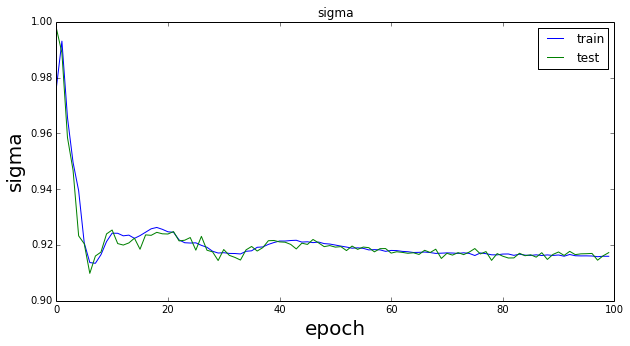

In [18]:
plt.figure(figsize=(10, 5))
plt.title('sigma')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('sigma', fontsize=20)
plt.xlim(0, 100)
# plt.ylim(8, 22)
plt.plot(main_sigma, label='train')
plt.plot(validation_main_sigma, label='test')
plt.legend(loc='best')
plt.show()

In [19]:
def decode(dataset):
    ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]  
    x = chainer.Variable(np.asarray(dataset[ind])) 
    with chainer.using_config('train', False), chainer.no_backprop_mode(): 
        mu, ln_var = model.encode(x) 
        average_mu = np.mean(mu.data)
        sigma = np.exp(ln_var.data/2)
        average_sigma = np.mean(sigma)
        return average_mu, average_sigma

In [20]:
mu, sigma = decode(train)
print('mu(0): {}'.format(mu))
print('sigma(1): {}'.format(sigma))

mu(0): -0.011452368460595608
sigma(1): 0.9216520190238953


In [21]:
mu, sigma = decode(test)
print('mu(0): {}'.format(mu))
print('sigma(1): {}'.format(sigma))

mu(0): -0.0031158204656094313
sigma(1): 0.9174661636352539


# 画像の符号化

In [46]:
# 100個取り出す。
fives = train[:100]
fives.shape

(100, 784)

In [47]:
# 符号化する。
xs = chainer.Variable(fives) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    five_mus, five_ln_vars = model.encode(xs) 

In [48]:
anomaly_label = 1
ones = extract_specified_labels(src_train, anomaly_label)[:10]
ones.shape

(10, 784)

In [49]:
# 符号化する。
xs = chainer.Variable(ones) 
with chainer.using_config('train', False), chainer.no_backprop_mode(): 
    one_mus, one_ln_vars = model.encode(xs) 

In [50]:
print(five_mus.data.shape)
print(one_mus.data.shape)

(100, 100)
(10, 100)


In [51]:
from sklearn.manifold import TSNE

In [52]:
# 次元を圧縮する。
reduced_fives = TSNE(n_components=2, random_state=0).fit_transform(five_mus.data)
reduced_ones = TSNE(n_components=2, random_state=0).fit_transform(one_mus.data)

In [53]:
print(reduced_fives.shape)
print(reduced_ones.shape)
reduced = np.concatenate([reduced_fives, reduced_ones], axis=0)
reduced.shape

(100, 2)
(10, 2)


(110, 2)

In [57]:
# ラベルを作成する。
five_labels = 1 * np.ones(reduced_fives.shape[0])
one_labels = 10 * np.ones(reduced_ones.shape[0]) 
print(five_labels.shape)
print(one_labels.shape)
labels = np.concatenate([five_labels, one_labels], axis=0)
print(labels.shape)

(100,)
(10,)
(110,)


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


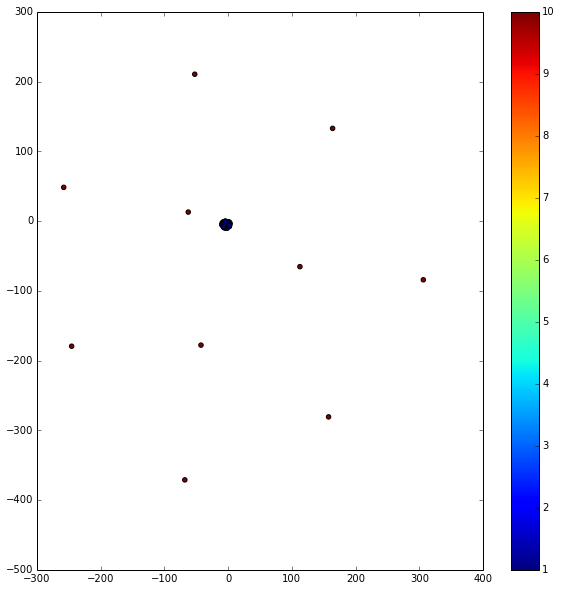

In [58]:
plt.figure(figsize=(10, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels)
plt.colorbar()
plt.show()